In [1]:
import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation

from dataset import MnistDataloader

Load data

In [2]:
input_path = Path('./data')

training_images_filepath = input_path/'train-images-idx3-ubyte/train-images-idx3-ubyte'
training_labels_filepath = input_path/'train-labels-idx1-ubyte/train-labels-idx1-ubyte'

test_images_filepath = input_path/'t10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = input_path/'t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

In [3]:
mnist_dataloader = MnistDataloader(training_images_filepath, 
                                   training_labels_filepath, 
                                   test_images_filepath, 
                                   test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Assume that we there is a particle move on the integer points $\in[0, m]$. Every unit time, it move to the right by $1$, but after it hit the $m$, it will reverse the direction of movement and moves to the left with the same speed. Assume that the particle starts at $0$, the following function calculates the location of particle as a function of time. 

Now assume that the particle moves with speed $s$ and starts at $i$, the function becomes:

In [4]:
def one_dim(time, interval_length, speed=1, initial_loc=0):
    loc = initial_loc + time * speed
    periodic_loc = loc % (2 * interval_length)
    return interval_length - abs(periodic_loc - interval_length)
one_dim = np.vectorize(one_dim)

def two_dim(time, 
            height, width, 
            speed_ver, speed_hor, 
            initial_ver, initial_hor):
    loc_ver = one_dim(time, height, speed_ver, initial_ver)
    loc_hor = one_dim(time, width, speed_hor, initial_hor)
    return loc_ver, loc_hor

two_dim = np.vectorize(two_dim)

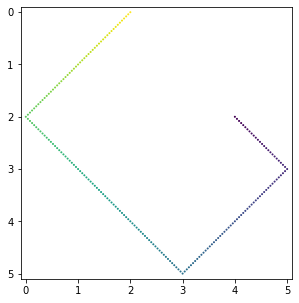

In [5]:
height, width = 5, 5
time = np.linspace(0, 4, 201)
loc_ver, loc_hor = two_dim(time, height, width, 2, 2, 2, 4)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.set_xlim(-.1, width + .1)
ax.set_ylim(-.1, height + .1)

ax.invert_yaxis()
ax.set_aspect(1)
plt.scatter(loc_hor, loc_ver, c=time, s=1)

In [6]:
class BlockTrail:
    def __init__(self,
                 block_height, 
                 block_width, 
                 frame_height, 
                 frame_width, 
                 speed_ver_range, 
                 speed_hor_range):
        
        self.block_height = block_height
        self.block_width  = block_width
        self.frame_height = frame_height
        self.frame_width  = frame_width
        
        # the height and width of the bounding box of the top-left corner
        self.height = frame_height - block_height
        self.width = frame_width - block_width
        
        self.speed_ver_range = speed_ver_range
        self.speed_hor_range = speed_hor_range
        
    def gen_random_trail_params(self, ):
        
        while True:
            speed_ver = random.randint(-self.speed_ver_range, self.speed_ver_range)
            speed_hor = random.randint(-self.speed_hor_range, self.speed_hor_range)
            if speed_ver != 0 or speed_hor != 0:
                break

        # random initial location in the bounding box
        initial_ver = random.randint(0, self.height)
        initial_hor = random.randint(0, self.width)
        
        return speed_ver, speed_hor, initial_ver, initial_hor
    
    def get_trail(self, total_time_steps, trail_params):        
        return two_dim(np.arange(total_time_steps), 
                       self.height, 
                       self.width, 
                       *trail_params)

In [7]:
def get_video(samples, trails,
              block_height, 
              block_width,
              frame_height, 
              frame_width):
    
    # generate the frames
    frames = np.zeros((total_time_steps, frame_height, frame_width))
    
    for sample, trail in zip(samples, trails):
        loc_ver, loc_hor = trail
        for step in range(len(loc_ver)):
            top, left = loc_ver[step], loc_hor[step]
            frames[step][top : top + block_height, left : left + block_width] += sample
    
    frames = np.clip(frames, 0, 255.)
    
    return frames

In [8]:
num_videos = 100_000

num_samples = 2

block_height    = 28
block_width     = 28
frame_height    = 64 
frame_width     = 64
speed_ver_range = 5 
speed_hor_range = 5

total_time_steps = 50

dataroot = Path('./dataset')
split = 'train'
dataset_path = dataroot/split
dataset_path.mkdir(exist_ok=True)

bt = BlockTrail(block_height    = block_height, 
                block_width     = block_width,
                frame_height    = frame_height, 
                frame_width     = frame_width,
                speed_ver_range = speed_ver_range, 
                speed_hor_range = speed_hor_range)

for video_idx in tqdm(range(num_videos)):
    
    indices = random.choices(range(len(y_train)), k = num_samples)
    
    samples = x_train[indices]
    
    trail_params_list = [bt.gen_random_trail_params() 
                         for _ in range(num_samples)]
    
    trails = [bt.get_trail(total_time_steps, trail_params) 
              for trail_params in trail_params_list]
    
    video = get_video(samples, trails,
                      block_height    = block_height, 
                      block_width     = block_width,
                      frame_height    = frame_height, 
                      frame_width     = frame_width)
    
    label = [(y_train[indices[sample_idx]], ) + trail_params_list[sample_idx][:2] 
             for sample_idx in range(num_samples)]
    
    np.savez_compressed(dataset_path/f'sample_{video_idx}.npz', 
                        video = video, 
                        label = np.array(label))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [21:54<00:00, 76.06it/s]


[[ 9 -5  0]
 [ 8  5  5]]


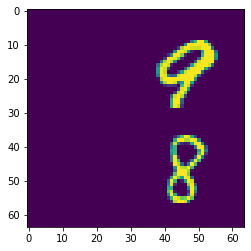

In [31]:
with np.load('dataset/train/sample_0.npz') as fh:
    video = fh['video']
    label = fh['label']
    print(label)

vmin, vmax = video.min(), video.max()

fig = plt.figure()
ims = []
for i in range(len(video)):
    im = plt.imshow(video[i], vmin=vmin, vmax=vmax)
    ims.append([im])

ani = ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)

ani.save('moving_mnist_test.mp4')